In [65]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from helpers import create_df, get_peaks_and_valleys, plot_df, get_num_reps, smooth_and_resample
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf



In [66]:
# 0 = bicep curl, 1 = shoulder press, 2 = row, 3 = rdl, 4 = squat 
training_files = {"../data2/bicep_curl/bicep_adam_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_mike_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_udai_set1_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv": 1,
                  "../data2/row/row_adam_set1_reps10_1.csv": 2, 
                  "../data2/row/row_andrew_set1_reps10_1.csv": 2, 
                  "../data2/row/row_anuj_set1_rep10_1.csv": 2, 
                  "../data2/row/row_jake_set1_reps12_1.csv": 2, 
                  "../data2/row/row_kamyar_set1_reps10_1.csv": 2, 
                  "../data2/row/row_mike_set1_reps10_1.csv": 2, 
                  "../data2/row/row_suzan_set1_reps10_1.csv": 2, 
                  "../data2/row/row_udai_set1_reps12_1.csv": 2, 
                  "../data2/dead/dead_adam_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_andrew_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_anuj_set1_rep10_1.csv": 3, 
                  "../data2/dead/dead_kamyar_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_mike_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_adam_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_andrew_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_anuj_set1_rep10_1.csv": 4, 
                  "../data2/squat/squat_jake_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_kamyar_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_mike_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_suzan_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_udai_set1_reps10_1.csv": 4,
                  "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv": 1, 
                  "../data2/row/row_udai_set3_reps10_1.csv": 2, 
                  "../data2/dead/dead_udai_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_udai_set3_reps10_1.csv": 4,
                  "../data2/newDead/newdead_udai_set1_reps10_1.csv": 3,
                  "../data2/newDead/newdead_udai_set2_reps10_1.csv": 3} 
train_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3] 

validation_files = [
                    "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv", 
                    "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv", 
                    "../data2/row/row_udai_set3_reps10_1.csv", 
                    "../data2/dead/dead_udai_set1_reps10_1.csv", 
                    "../data2/squat/squat_udai_set3_reps10_1.csv"] 

validation_labels = [0, 1, 2, 3, 4] 

test_files = {"../data2/bicep_curl/bicep_adam_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv": 0, 
              "../data2/bicep_curl/bicep_jake_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_kamyar_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_mike_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_suzan_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_udai_set2_reps10_1.csv": 0, 
              "../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_anuj_set2_rep10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_kamyar_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_mike_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set4_reps10_1.csv": 1,
              "../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv": 1, 
              "../data2/row/row_adam_set2_reps10_1.csv": 2, 
              "../data2/row/row_andrew_set2_reps10_1.csv": 2, 
              "../data2/row/row_anuj_set2_rep10_1.csv": 2, 
              "../data2/row/row_jake_set2_reps12_1.csv": 2, 
              "../data2/row/row_kamyar_set2_reps10_1.csv": 2, 
              "../data2/row/row_mike_set2_reps10_1.csv": 2, 
              "../data2/row/row_suzan_set2_reps12_1.csv": 2, 
              "../data2/row/row_udai_set2_reps12_1.csv": 2, 
              "../data2/dead/dead_adam_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_andrew_set2_reps10_1.csv": 3,
              "../data2/dead/dead_anuj_set2_rep10_1.csv": 3, 
              "../data2/dead/dead_kamyar_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_mike_set2_reps10_1.csv": 3, 
              "../data2/squat/squat_adam_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_andrew_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_anuj_set2_rep10_1.csv": 4, 
              "../data2/squat/squat_jake_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_kamyar_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_mike_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_suzan_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_udai_set2_reps10_1.csv": 4,
              } 

test_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3]

In [67]:
def autocorr(x, lag=1):
    return np.corrcoef(x[:-lag], x[lag:])[0,1]

def extract_features(df):
    print(f"extract_features")
    features = {}
    features["duration"] = df["timestamp"].iloc[-1] - df["timestamp"].iloc[0]
    for col in df:
        if col != "timestamp":
            data = df[col].values
            features[f"{col}_mean"] = np.mean(data)
            features[f"{col}_std"] = np.std(data)
            features[f"{col}_10th"] = np.percentile(data, 10)
            features[f"{col}_25th"] = np.percentile(data, 25)
            features[f"{col}_75th"] = np.percentile(data, 75)
            features[f"{col}_90th"] = np.percentile(data, 90)
            features[f"{col}_std"] = np.std(data)
            features[f"{col}_rms"] = np.sqrt(np.mean(data**2))

            fft_vals = np.fft.rfft(data)
            fft_freqs = np.fft.rfftfreq(len(data), d=1/100)  # adjust 100 to your Hz
            fft_mag = np.abs(fft_vals)
            features[col + "_band_low"]  = np.sum(fft_mag[(fft_freqs >= 0) & (fft_freqs < 2)])
            features[col + "_band_mid"]  = np.sum(fft_mag[(fft_freqs >= 2) & (fft_freqs < 5)])
            features[col + "_band_high"] = np.sum(fft_mag[(fft_freqs >= 5) & (fft_freqs <= 10)])

    return features

In [68]:
X_train = pd.DataFrame()
y_train = []

for file, label in training_files.items():
    df = create_df(file)
    features = extract_features(df)
    y_train.append(label)
    # print(f"features: {features}")
    X_train = pd.concat([X_train, pd.DataFrame([features])], ignore_index=True)

print(X_train)


../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     304079   -0.834    3.319    9.444   0.098  -0.054   0.012
1     304082   -0.824    3.326    9.452   0.098  -0.054   0.012
2     304085   -0.824    3.326    9.452   0.097  -0.053   0.012
3     304089   -0.824    3.326    9.452   0.097  -0.053   0.012
4     304110   -0.846    3.269    9.446   0.122  -0.056   0.007
extract_features
../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0    1783092    0.522    4.887   -8.289  -0.454  -0.057  -0.042
1    1783096    0.536    4.859   -8.264  -0.519  -0.046  -0.043
2    1783099    0.536    4.859   -8.264  -0.519  -0.046  -0.043
3    1783103    0.536    4.859   -8.264  -0.519  -0.046  -0.043
4    1783126    0.474    4.851   -8.181  -0.552  -0.057  -0.049
extract_features
../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  g

In [69]:
X_train = pd.DataFrame()
y_train = []

for file, label in training_files.items():
    df = create_df(file)
    features = extract_features(df)
    y_train.append(label)
    # print(f"features: {features}")
    X_train = pd.concat([X_train, pd.DataFrame([features])], ignore_index=True)

print(X_train)


../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     304079   -0.834    3.319    9.444   0.098  -0.054   0.012
1     304082   -0.824    3.326    9.452   0.098  -0.054   0.012
2     304085   -0.824    3.326    9.452   0.097  -0.053   0.012
3     304089   -0.824    3.326    9.452   0.097  -0.053   0.012
4     304110   -0.846    3.269    9.446   0.122  -0.056   0.007
extract_features
../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0    1783092    0.522    4.887   -8.289  -0.454  -0.057  -0.042
1    1783096    0.536    4.859   -8.264  -0.519  -0.046  -0.043
2    1783099    0.536    4.859   -8.264  -0.519  -0.046  -0.043
3    1783103    0.536    4.859   -8.264  -0.519  -0.046  -0.043
4    1783126    0.474    4.851   -8.181  -0.552  -0.057  -0.049
extract_features
../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  g

In [70]:
X_test = pd.DataFrame()
y_test = []

for file, label in test_files.items():
    df = create_df(file)
    features = extract_features(df)
    y_test.append(label)
    # print(f"features: {features}")
    X_test = pd.concat([X_test, pd.DataFrame([features])], ignore_index=True)

print(X_test)


../data2/bicep_curl/bicep_adam_set2_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     483292   -0.487   -0.382   10.006   0.156  -0.081  -0.035
1     483296   -0.487   -0.382   10.006   0.156  -0.081  -0.035
2     483300   -0.487   -0.382   10.006   0.156  -0.081  -0.035
3     483303   -0.471   -0.383   10.004   0.154  -0.084  -0.035
4     483325   -0.434   -0.361   10.025   0.148  -0.088  -0.038
extract_features
../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0    2823131   -0.607   -9.600   -2.028   0.089  -0.117  -0.039
1    2823134   -0.607   -9.600   -2.039   0.089  -0.117  -0.039
2    2823138   -0.577   -9.570   -2.039   0.109  -0.123  -0.043
3    2823245   -0.621   -9.514   -2.047   0.049  -0.108  -0.046
4    2823282   -0.650   -9.497   -2.061   0.092  -0.106  -0.046
extract_features
../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  g

In [71]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [72]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Accuracy: 83.78%


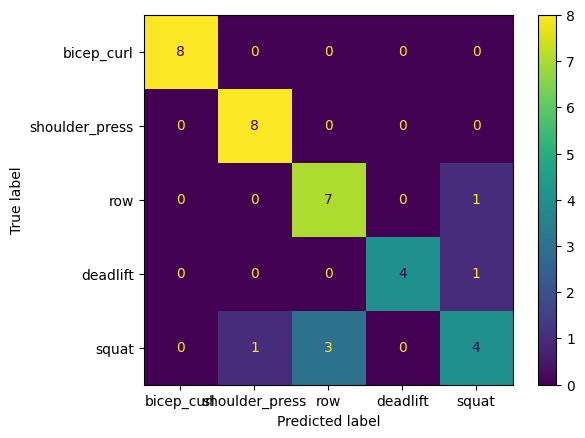

In [73]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

cm = confusion_matrix(y_test, y_pred)

class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()